In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import interpolate

In [2]:
import scipy

In [3]:
import pandas as pd

In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 8)

In [6]:
from scipy.interpolate import interp1d

35.708000000000006
potential written
dvr is set up


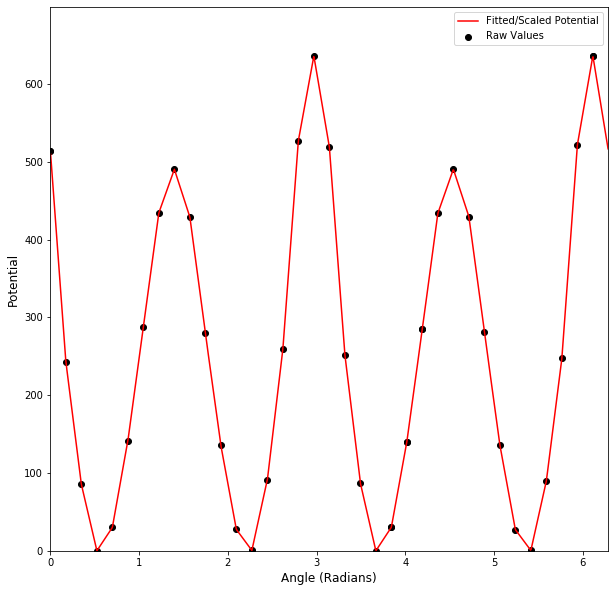

In [17]:
# Run and collect ground state

# Reduced mass of freqency calculation =  3.5708    AMU

mass_ground = 3.5708*1836*10
print(str(mass_ground/1836))

num_wavefunctions_ground = 5
grid_points = 500


fit_linear_potential_assume_periodic_write_to_file(raw_potential_filename='kidwell_gs_scan_no_water_raw_pot_zpe.dat',num_grid_points=grid_points,
                                output_potential_filename='gs_scan_no_water_fitted_zpe.dat',shift_origin=0.0,scale_factor=1.00)


print('potential written')

setup_dvr(num_states=num_wavefunctions_ground,num_grid_points=grid_points,mass=mass_ground,
                         potential_energy_file_name='gs_scan_no_water_fitted_zpe.dat',
                        output_file_name='kidwell_gs_scan_no_h2o_zpe')

print('dvr is set up')
# Now need to make the output potential the potential_file.dat and run 
# ./dvr_1d_periodic

107.358
potential written
dvr is set up


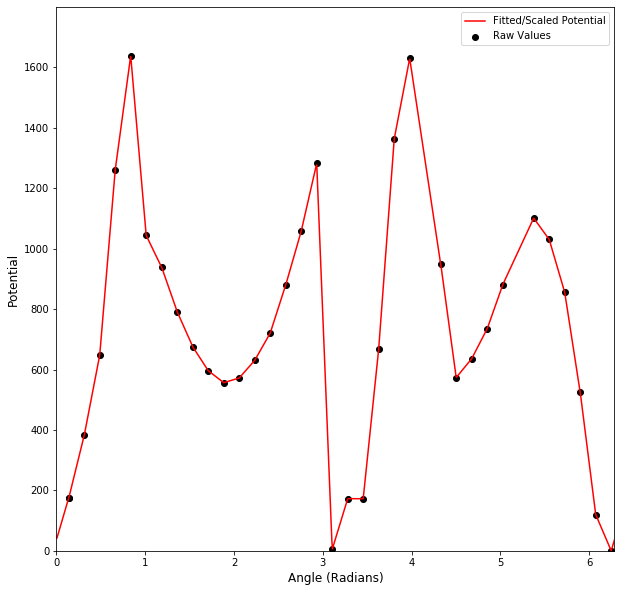

In [18]:
# run DVR
# Now run excited state
# Base the mass on the excited state torsoinal frequency calculation
# Mass output is    3.5786  
mass_excited =   3.5786*1836*30
num_wavefunctions_excited = 200
print(str(mass_excited/1836))

# Trying pure linear interpolation. The old cubic spline is below
#fit_potential_assume_periodic_write_to_file(raw_potential_filename='kidwell_es_scan_with_water_raw_pot_with_zpe.dat',num_grid_points=grid_points,
#                                output_potential_filename='es_scan_with_water_fitted_zpe.dat',shift_origin=0.0,scale_factor=1.0)

fit_linear_potential_assume_periodic_write_to_file(raw_potential_filename='kidwell_es_scan_no_water_raw_pot_with_zpe.dat',num_grid_points=grid_points,
                                output_potential_filename='es_scan_no_water_fitted_zpe.dat',shift_origin=0.0,scale_factor=1.0)

print('potential written')

setup_dvr(num_states=num_wavefunctions_excited,num_grid_points=grid_points,mass=mass_excited,
                         potential_energy_file_name='es_scan_no_water_fitted_zpe.dat',
                        output_file_name='kidwell_es_scan_no_h2o_zpe')

print('dvr is set up')

In [19]:
# run dvr

In [20]:
def read_wavefunctions_calculate_overlaps_vib_shift(ground_state_file_name_root=None,
                                         excited_state_file_name_root=None,
                                         max_num_ground_state_wfs=0,
                                         max_num_excited_state_wfs=0,
                                         ground_state_max_energy=0,
                                         excited_state_max_energy=0,
                                                   vib_shift=0,
                                                   vib_scale=1.0):
    
# now read in wavefunctions and energies and calculate
    ground_state_dict = read_dvr_output(filename_root=ground_state_file_name_root,num_states=max_num_ground_state_wfs)
    excited_state_dict = read_dvr_output(filename_root=excited_state_file_name_root,num_states=max_num_excited_state_wfs)

# Normalize ground electronic state nuclear wavefunctions

    for state_key,state_information in ground_state_dict.items():
        normalization_constant = calculate_wavefunction_overlap(wavefunction_1_angles=state_information['wavefunction_angles'],
                                   wavefunction_1_values=state_information['wavefunction_values'],
                                  wavefunction_2_angles=state_information['wavefunction_angles'],
                                   wavefunction_2_values=state_information['wavefunction_values'])
    
        state_information['wavefunction_values'] = state_information['wavefunction_values']/np.sqrt(normalization_constant)
    
    # Normalize excited state

    for state_key,state_information in excited_state_dict.items():
        normalization_constant = calculate_wavefunction_overlap(wavefunction_1_angles=state_information['wavefunction_angles'],
                                   wavefunction_1_values=state_information['wavefunction_values'],
                                  wavefunction_2_angles=state_information['wavefunction_angles'],
                                   wavefunction_2_values=state_information['wavefunction_values'])
    
#    print(str(normalization_constant))
    
        state_information['wavefunction_values'] = state_information['wavefunction_values']/np.sqrt(normalization_constant)
    
    # Need to calculate pairs of overlaps. This is an N^2 process
    # But it can be pruned

    overlap_dicts =list() # This is a list of dicts. 

    # Find the minimum ground state energy 
    
    min_ground_energy = 9999999
    
    for ground_state_key,ground_state_information in ground_state_dict.items():
        if ground_state_information['energy'] < min_ground_energy:
            min_ground_energy = ground_state_information['energy']
    
    # Find the minimum excited state energy 
    
    min_excited_energy = 99999999
    
    for excited_state_key,excited_state_information in excited_state_dict.items():
        if excited_state_information['energy'] < min_excited_energy:
            min_excited_energy = excited_state_information['energy']
    
    for ground_state_key,ground_state_information in ground_state_dict.items():
        for excited_state_key,excited_state_information in excited_state_dict.items():
            current_dict = dict()
            # Check the energy 
            if ground_state_information['energy']*AU_TO_WAVENUMBER < ground_state_max_energy:
                if excited_state_information['energy']*AU_TO_WAVENUMBER < excited_state_max_energy:
                    relative_energy = excited_state_information['energy'] - min_excited_energy
                    # correct for being above the ground state
                    
                    relative_energy = relative_energy - (ground_state_information['energy']-min_ground_energy)

                    print('Calculating overlap for transition with energy '+str(relative_energy*AU_TO_WAVENUMBER))

                    
                    overlap = calculate_wavefunction_overlap(wavefunction_1_angles=ground_state_information['wavefunction_angles'],
                                   wavefunction_1_values=ground_state_information['wavefunction_values'],
                                  wavefunction_2_angles=excited_state_information['wavefunction_angles'],
                                   wavefunction_2_values=excited_state_information['wavefunction_values'])
                    
                    # now add to dictionary 
                    current_dict['energy'] = relative_energy
                    current_dict['ground_state_id'] = ground_state_key
                    current_dict['excited_state_id'] = excited_state_key
                    current_dict['overlap'] = abs(overlap)
                    
                    
                    
                    overlap_dicts.append(current_dict)
                    
                    # now add the vibrational shifted level 
                    
                    if excited_state_information['energy']*AU_TO_WAVENUMBER+vib_shift < excited_state_max_energy:
                        current_dict = dict()
                        current_dict['energy'] = relative_energy + vib_shift/AU_TO_WAVENUMBER
                        current_dict['ground_state_id'] = ground_state_key+'_vib_excited'
                        current_dict['excited_state_id'] = excited_state_key+'_vib_excited'
                        current_dict['overlap'] = abs(overlap)*vib_scale
                        overlap_dicts.append(current_dict)
                    
    return overlap_dicts

In [21]:
wavefunction_overlaps = read_wavefunctions_calculate_overlaps_vib_shift(
                                         ground_state_file_name_root='kidwell_gs_scan_no_h2o_zpe',
                                         excited_state_file_name_root='kidwell_es_scan_no_h2o_zpe',
                                         max_num_ground_state_wfs=4,
                                         max_num_excited_state_wfs=100,
                                         ground_state_max_energy=300,
                                         excited_state_max_energy=3000,
                                         vib_shift=200.0,
                                        vib_scale=1.0)

Calculating overlap for transition with energy 0.0
Calculating overlap for transition with energy 58.33028747814011
Calculating overlap for transition with energy 103.86479375672907
Calculating overlap for transition with energy 148.63225908593498
Calculating overlap for transition with energy 190.55580176202884
Calculating overlap for transition with energy 247.29980077260245
Calculating overlap for transition with energy 279.5346027675269
Calculating overlap for transition with energy 360.93941269775394
Calculating overlap for transition with energy 373.1441254942123
Calculating overlap for transition with energy 439.21089123838345
Calculating overlap for transition with energy 505.82207753475353
Calculating overlap for transition with energy 507.20509696052125
Calculating overlap for transition with energy 514.6310325043988
Calculating overlap for transition with energy 549.663699916409
Calculating overlap for transition with energy 565.5531277840857
Calculating overlap for transiti

Calculating overlap for transition with energy 1179.4807848081382
Calculating overlap for transition with energy 1192.4373851308328
Calculating overlap for transition with energy 1219.0492457845419
Calculating overlap for transition with energy 1225.002682435233
Calculating overlap for transition with energy 1247.1952583085933
Calculating overlap for transition with energy 1259.5356696755832
Calculating overlap for transition with energy 1278.6240788780808
Calculating overlap for transition with energy 1293.1403028463994
Calculating overlap for transition with energy 1318.9092265331326
Calculating overlap for transition with energy 1328.0382191581364
Calculating overlap for transition with energy 1355.0983645533968
Calculating overlap for transition with energy 1362.305260126057
Calculating overlap for transition with energy 1386.8038616237732
Calculating overlap for transition with energy 1397.430318241189
Calculating overlap for transition with energy 1423.4340139011792
Calculating o

In [22]:
wavefunction_overlaps

[{'energy': 0.0,
  'ground_state_id': 'kidwell_gs_scan_no_h2o_zpe_0',
  'excited_state_id': 'kidwell_es_scan_no_h2o_zpe_0',
  'overlap': 0.00020272800453104386},
 {'energy': 0.0009112670562424458,
  'ground_state_id': 'kidwell_gs_scan_no_h2o_zpe_0_vib_excited',
  'excited_state_id': 'kidwell_es_scan_no_h2o_zpe_0_vib_excited',
  'overlap': 0.00020272800453104386},
 {'energy': 0.0002657723467999017,
  'ground_state_id': 'kidwell_gs_scan_no_h2o_zpe_0',
  'excited_state_id': 'kidwell_es_scan_no_h2o_zpe_1',
  'overlap': 5.588647872270281e-07},
 {'energy': 0.0011770394030423475,
  'ground_state_id': 'kidwell_gs_scan_no_h2o_zpe_0_vib_excited',
  'excited_state_id': 'kidwell_es_scan_no_h2o_zpe_1_vib_excited',
  'overlap': 5.588647872270281e-07},
 {'energy': 0.00047324282426961634,
  'ground_state_id': 'kidwell_gs_scan_no_h2o_zpe_0',
  'excited_state_id': 'kidwell_es_scan_no_h2o_zpe_2',
  'overlap': 0.0005420036305544889},
 {'energy': 0.001384509880512062,
  'ground_state_id': 'kidwell_gs_scan_

In [23]:
overlap_df = pd.DataFrame(wavefunction_overlaps)

In [24]:
overlap_df

energy                           ground_state_id  \
0    0.000000              kidwell_gs_scan_no_h2o_zpe_0   
1    0.000911  kidwell_gs_scan_no_h2o_zpe_0_vib_excited   
2    0.000266              kidwell_gs_scan_no_h2o_zpe_0   
3    0.001177  kidwell_gs_scan_no_h2o_zpe_0_vib_excited   
4    0.000473              kidwell_gs_scan_no_h2o_zpe_0   
..        ...                                       ...   
795  0.010279  kidwell_gs_scan_no_h2o_zpe_3_vib_excited   
796  0.009375              kidwell_gs_scan_no_h2o_zpe_3   
797  0.010286  kidwell_gs_scan_no_h2o_zpe_3_vib_excited   
798  0.009613              kidwell_gs_scan_no_h2o_zpe_3   
799  0.010524  kidwell_gs_scan_no_h2o_zpe_3_vib_excited   

                              excited_state_id       overlap  
0                 kidwell_es_scan_no_h2o_zpe_0  2.027280e-04  
1     kidwell_es_scan_no_h2o_zpe_0_vib_excited  2.027280e-04  
2                 kidwell_es_scan_no_h2o_zpe_1  5.588648e-07  
3     kidwell_es_scan_no_h2o_zpe_1_vib_excited  5.588648e-07  
4                 kidwell_es_scan_no_h2o_zpe_2  5.420036e-04  
..                                         ...           ...  
795  kidwell_es_scan_no_h2o_zpe_97_vib_excited  1.107147e-04  
796              kidwell_es_scan_no_h2o_zpe_98  4.244484e-03  
797  kidwell_es_scan_no_h2o_zpe_98_vib_excited  4.244484e-03  
798              kidwell_es_scan_no_h2o_zpe_99  8.804308e-04  
799  kidwell_es_scan_no_h2o_zpe_99_vib_excited  8.804308e-04  

[800 rows x 4 columns]

<ipython-input-25-6593e258c9fb>:56: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(wavefunction_ground_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset,
<ipython-input-25-6593e258c9fb>:62: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(wavefunction_excited_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset,


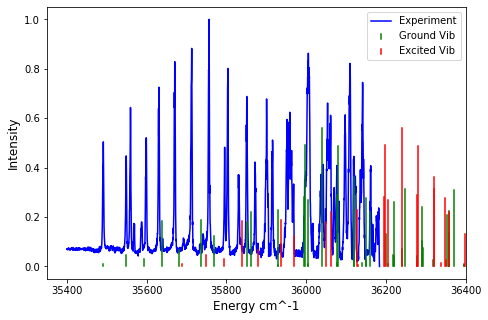

In [25]:
# Now, convert from a.u. to cm^-1, plot stem plot and compare to the experimental spectrum

offset = 35490

kidwell_uv_spectrum_energy = np.loadtxt('PhPy UV Spectrum.txt',usecols=0)
kidwell_uv_spectrum_intensity = np.loadtxt('PhPy UV Spectrum.txt',usecols=1)

# Set baseline to zero 

kidwell_uv_spectrum_intensity = kidwell_uv_spectrum_intensity-min(kidwell_uv_spectrum_intensity)

# Normalize
kidwell_uv_spectrum_intensity = kidwell_uv_spectrum_intensity/max(kidwell_uv_spectrum_intensity)

fig = plt.figure(figsize = (7.5,5))
ax = fig.add_subplot(1,1,1) 

#ax.set_xlim(min(kidwell_uv_spectrum_energy)-200,max(kidwell_uv_spectrum_energy)+400)

ax.set_xlabel('Energy cm^-1', fontsize = 12)
ax.set_ylabel('Intensity', fontsize = 12)
# ax.set_title('Masses set to '+str(mass_ground)+' , '+str(mass_excited) + ' atomic units', fontsize = 12)
ax.set_xlim(35350,36400)
 
#ax.plot(angles, kidwell_gs_with_h2o_interpolate_values*AU_TO_WAVENUMBER,label='Kidwell GS Potential with Water', color='r',ls='-')
ax.plot(kidwell_uv_spectrum_energy, kidwell_uv_spectrum_intensity,label='Experiment', color='b',ls='-')

# Scale the overlaps that come from the excited state

wavefunction_overlaps_for_plotting = wavefunction_overlaps.copy()

wavefunction_ground_vib_state_for_plotting = list()
wavefunction_excited_vib_state_for_plotting = list()

# Want to have different colors depending on if the origin is 
for wavefunction_overlap in wavefunction_overlaps_for_plotting:
    if 'vib_excited' in wavefunction_overlap['excited_state_id']:
        wavefunction_excited_vib_state_for_plotting.append(wavefunction_overlap)
    else:
        wavefunction_ground_vib_state_for_plotting.append(wavefunction_overlap)

# Now add in the stem plot

vibrational_state_overlaps_df = pd.DataFrame(wavefunction_overlaps_for_plotting)

# Might need to normalize

wavefunction_ground_vib_state_for_plotting_df = pd.DataFrame(wavefunction_ground_vib_state_for_plotting)

wavefunction_excited_vib_state_for_plotting_df = pd.DataFrame(wavefunction_excited_vib_state_for_plotting)

#ax.stem(vibrational_state_overlaps_df['energy']*AU_TO_WAVENUMBER+offset, 
#        vibrational_state_overlaps_df['overlap'],linefmt='g-',markerfmt=' ',label='All',
#       basefmt=" ")

ax.stem(wavefunction_ground_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset, 
        wavefunction_ground_vib_state_for_plotting_df['overlap'],linefmt='g-',markerfmt=' ',label='Ground Vib',
       basefmt=" ")

#print(wavefunction_ground_vib_state_for_plotting_df)

ax.stem(wavefunction_excited_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset, 
      wavefunction_excited_vib_state_for_plotting_df['overlap'],linefmt='r-',markerfmt=' ',label='Excited Vib',
       basefmt=" ")


#ax.stem(ground_vibrational_state_overlaps_df['energy']*AU_TO_WAVENUMBER+offset, 
#        ground_vibrational_state_overlaps_df['overlap'],linefmt='g-',markerfmt=' ',label='n=0 ground origin',
 #      basefmt=" ")

ax.legend()
plt.savefig('./theory_exp_spectrum_compare_mass_'+str(mass_ground)+'_'+str(mass_excited)+'_no_water_zpe_for_presentation.pdf')
plt.show()

In [26]:
# Plot now with linewidth
# Reads in a list of frequencies and intensities
# Then produces two text files that have the right spectrum
def calc_spectrum_plot(freq_list=None,int_list=None,
                       min_freq=0.0,max_freq=0.0,width=1,resolution=0.05):
    
    num_points = int((max_freq-min_freq)/(resolution))
    
    frequencies = list()
    intensities = list()
    
    for i in range(0,num_points):
        frequency = min_freq+i*resolution
        intensity = 0.0
        
        for j in range(0,len(freq_list)):
            peak_center = freq_list[j]
            peak_height = int_list[j]
           # print(peak_center)
           # print(peak_height)
            intensity = intensity + peak_height*np.exp(-(frequency - peak_center)**2/(2*width))
    
        frequencies.append(frequency)
        intensities.append(intensity)
    
    return frequencies,intensities


In [27]:
theory_frequencies,theory_intensities = calc_spectrum_plot(
                    freq_list=vibrational_state_overlaps_df['energy']*AU_TO_WAVENUMBER+offset,
                    int_list=vibrational_state_overlaps_df['overlap'],
                       min_freq=offset-100,max_freq=offset+3000,width=10.0,resolution=1.0)

<ipython-input-49-6de24b576a35>:67: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(wavefunction_ground_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset,
<ipython-input-49-6de24b576a35>:73: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(wavefunction_excited_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset,


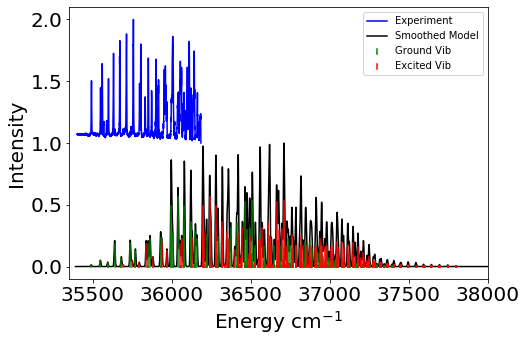

In [49]:
# Plot with both spectra on each other
#kidwell_uv_spectrum_energy = np.loadtxt('PhPy UV Spectrum.txt',usecols=0)
#kidwell_uv_spectrum_intensity = np.loadtxt('PhPy UV Spectrum.txt',usecols=1)
# Set baseline to zero 

kidwell_uv_spectrum_energy = np.loadtxt('PhPy UV Spectrum.txt',usecols=0)
kidwell_uv_spectrum_intensity = np.loadtxt('PhPy UV Spectrum.txt',usecols=1)

# Set baseline to zero 

kidwell_uv_spectrum_intensity = kidwell_uv_spectrum_intensity-min(kidwell_uv_spectrum_intensity)

# Normalize
kidwell_uv_spectrum_intensity = kidwell_uv_spectrum_intensity/max(kidwell_uv_spectrum_intensity)

fig = plt.figure(figsize = (7.5,5))
ax = fig.add_subplot(1,1,1) 

#ax.set_xlim(min(kidwell_uv_spectrum_energy)-200,max(kidwell_uv_spectrum_energy)+400)

ax.set_xlabel('Energy cm$^{-1}$', fontsize = 20)
ax.set_ylabel('Intensity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)

# ax.set_title('Masses set to '+str(mass_ground)+' , '+str(mass_excited) + ' atomic units', fontsize = 12)
ax.set_xlim(35350,38000)

max_freq = 38000
 
#ax.plot(angles, kidwell_gs_with_h2o_interpolate_values*AU_TO_WAVENUMBER,label='Kidwell GS Potential with Water', color='r',ls='-')
ax.plot(kidwell_uv_spectrum_energy, kidwell_uv_spectrum_intensity+1.0,label='Experiment', color='b',ls='-')


theory_plot_intensities = theory_intensities/max(theory_intensities)

# Plot the theory spectrum
ax.plot(theory_frequencies, theory_plot_intensities,label='Smoothed Model', color='k',ls='-')

# Scale the overlaps that come from the excited state

wavefunction_overlaps_for_plotting = wavefunction_overlaps.copy()

wavefunction_ground_vib_state_for_plotting = list()
wavefunction_excited_vib_state_for_plotting = list()

# Want to have different colors depending on if the origin is 
for wavefunction_overlap in wavefunction_overlaps_for_plotting:
    if 'vib_excited' in wavefunction_overlap['excited_state_id']:
        wavefunction_excited_vib_state_for_plotting.append(wavefunction_overlap)
    else:
        wavefunction_ground_vib_state_for_plotting.append(wavefunction_overlap)

# Now add in the stem plot

vibrational_state_overlaps_df = pd.DataFrame(wavefunction_overlaps_for_plotting)

# Might need to normalize

wavefunction_ground_vib_state_for_plotting_df = pd.DataFrame(wavefunction_ground_vib_state_for_plotting)

wavefunction_excited_vib_state_for_plotting_df = pd.DataFrame(wavefunction_excited_vib_state_for_plotting)

#ax.stem(vibrational_state_overlaps_df['energy']*AU_TO_WAVENUMBER+offset, 
#        vibrational_state_overlaps_df['overlap'],linefmt='g-',markerfmt=' ',label='All',
#       basefmt=" ")

ax.stem(wavefunction_ground_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset, 
        wavefunction_ground_vib_state_for_plotting_df['overlap'],linefmt='g-',markerfmt=' ',label='Ground Vib',
       basefmt=" ")

#print(wavefunction_ground_vib_state_for_plotting_df)

ax.stem(wavefunction_excited_vib_state_for_plotting_df['energy']*AU_TO_WAVENUMBER+offset, 
      wavefunction_excited_vib_state_for_plotting_df['overlap'],linefmt='r-',markerfmt=' ',label='Excited Vib',
       basefmt=" ")


#ax.stem(ground_vibrational_state_overlaps_df['energy']*AU_TO_WAVENUMBER+offset, 
#        ground_vibrational_state_overlaps_df['overlap'],linefmt='g-',markerfmt=' ',label='n=0 ground origin',
 #      basefmt=" ")

ax.legend()
plt.savefig('./theory_exp_spectrum_smooth_masses_'+str(mass_ground)+'_'+str(mass_excited)+'_no_water_zpe_for_presentation.pdf',bbox_inches='tight')
plt.show()



In [29]:
# Plot the lowest 4 ground state wavefunctions
ground_state_file_name_root='kidwell_gs_scan_no_h2o_zpe'
excited_state_file_name_root='kidwell_es_scan_no_h2o_zpe'
max_num_ground_state_wfs=4
max_num_excited_state_wfs=100


In [30]:
ground_state_dict = read_dvr_output(filename_root=ground_state_file_name_root,num_states=max_num_ground_state_wfs)
excited_state_dict = read_dvr_output(filename_root=excited_state_file_name_root,num_states=max_num_excited_state_wfs)


Examining state kidwell_gs_scan_no_h2o_zpe_0


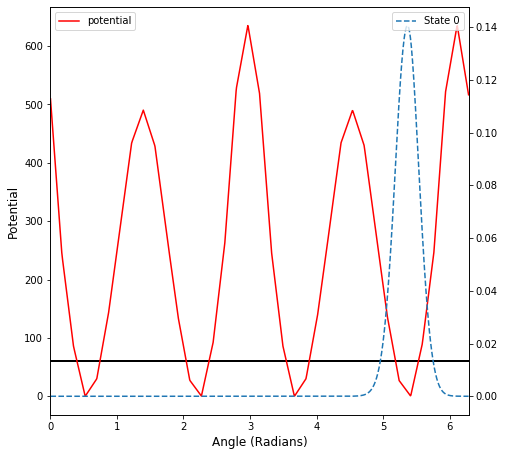

Examining state kidwell_gs_scan_no_h2o_zpe_1


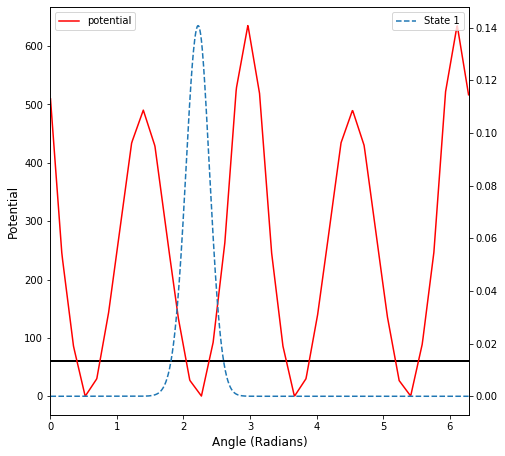

Examining state kidwell_gs_scan_no_h2o_zpe_2


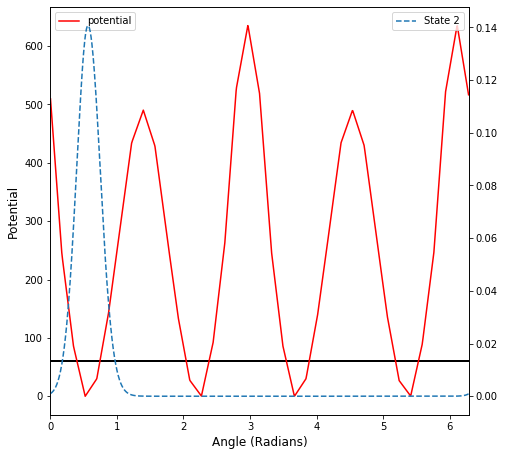

In [31]:
wavefunction_counter = 0

max_wavefunctions = 4

prefix = "kidwell_gs_scan_no_h2o_zpe"

styles=['--','.','s','o']

for i in range(0,3):
    plot_wavefunction(state_dict=ground_state_dict,
                        state_num=i,prefix="kidwell_gs_scan_no_h2o_zpe_",
                      plotting_potential_name="gs_scan_no_water_fitted_zpe.dat",
                     potential="Ground State PES",mass=mass_ground)
    
    
    

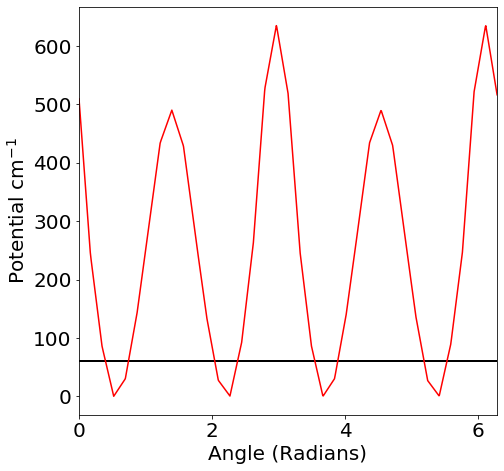

In [43]:
plot_potential_and_energy_levels(state_dict=ground_state_dict,
                       prefix="kidwell_gs_scan_no_h2o_zpe_",
                      plotting_potential_name="gs_scan_no_water_fitted_zpe.dat",
                     potential="Ground State PES",mass=mass_ground,max_energy=200)

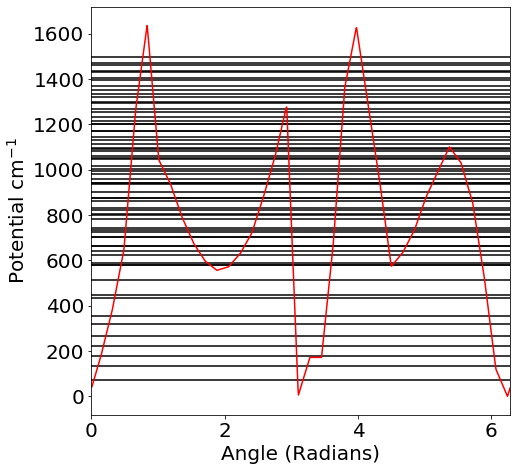

In [42]:
plot_potential_and_energy_levels(state_dict=excited_state_dict,
                       prefix="kidwell_es_scan_no_h2o_zpe_",
                      plotting_potential_name="es_scan_no_water_fitted_zpe.dat",
                     potential="Excited State PES",mass=mass_ground,max_energy=1500)

Examining state kidwell_gs_scan_with_h2o_zpe_0


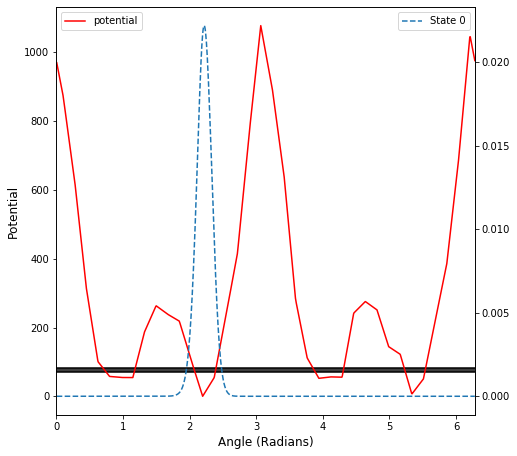

Examining state kidwell_gs_scan_with_h2o_zpe_1


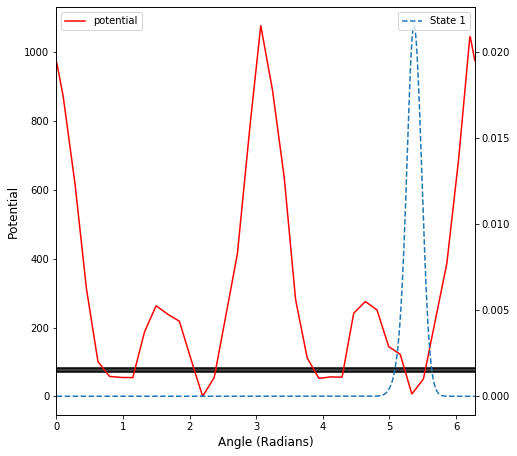

Examining state kidwell_gs_scan_with_h2o_zpe_2


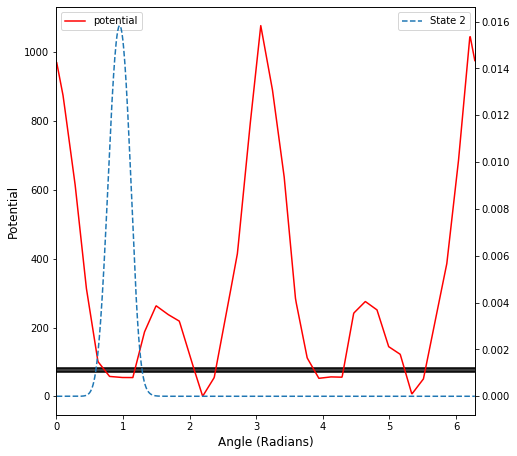

Examining state kidwell_gs_scan_with_h2o_zpe_3


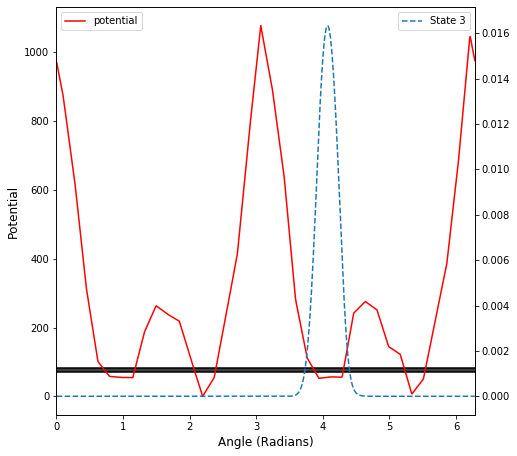

In [109]:
wavefunction_counter = 0

max_wavefunctions = 4

prefix = "kidwell_gs_scan_with_h2o_zpe"

styles=['--','.','s','o']

for i in range(0,4):
    plot_wavefunction_squared(state_dict=ground_state_dict,
                        state_num=i,prefix="kidwell_gs_scan_with_h2o_zpe_",
                      plotting_potential_name="gs_scan_with_water_fitted_zpe.dat",
                     potential="Ground State PES",mass=mass_ground)

In [117]:
# Get maximum overlaps so we can plot those excited state wavefunctions
overlap_df.sort_values(by=['overlap'],ascending=False).head(20)

energy                             ground_state_id  \
258  0.000013              kidwell_gs_scan_with_h2o_zpe_2   
259  0.000901  kidwell_gs_scan_with_h2o_zpe_2_vib_excited   
263  0.001163  kidwell_gs_scan_with_h2o_zpe_2_vib_excited   
262  0.000275              kidwell_gs_scan_with_h2o_zpe_2   
389  0.001094  kidwell_gs_scan_with_h2o_zpe_3_vib_excited   
388  0.000206              kidwell_gs_scan_with_h2o_zpe_3   
385  0.000840  kidwell_gs_scan_with_h2o_zpe_3_vib_excited   
384 -0.000048              kidwell_gs_scan_with_h2o_zpe_3   
402  0.001245              kidwell_gs_scan_with_h2o_zpe_3   
403  0.002134  kidwell_gs_scan_with_h2o_zpe_3_vib_excited   
205  0.006540  kidwell_gs_scan_with_h2o_zpe_1_vib_excited   
204  0.005652              kidwell_gs_scan_with_h2o_zpe_1   
392  0.000545              kidwell_gs_scan_with_h2o_zpe_3   
393  0.001433  kidwell_gs_scan_with_h2o_zpe_3_vib_excited   
267  0.001486  kidwell_gs_scan_with_h2o_zpe_2_vib_excited   
266  0.000597              kidwell_gs_scan_with_h2o_zpe_2   
208  0.005901              kidwell_gs_scan_with_h2o_zpe_1   
209  0.006790  kidwell_gs_scan_with_h2o_zpe_1_vib_excited   
200  0.005387              kidwell_gs_scan_with_h2o_zpe_1   
201  0.006275  kidwell_gs_scan_with_h2o_zpe_1_vib_excited   

                                excited_state_id   overlap  
258               kidwell_es_scan_with_h2o_zpe_1  0.609809  
259   kidwell_es_scan_with_h2o_zpe_1_vib_excited  0.609809  
263   kidwell_es_scan_with_h2o_zpe_3_vib_excited  0.471349  
262               kidwell_es_scan_with_h2o_zpe_3  0.471349  
389   kidwell_es_scan_with_h2o_zpe_2_vib_excited  0.462096  
388               kidwell_es_scan_with_h2o_zpe_2  0.462096  
385   kidwell_es_scan_with_h2o_zpe_0_vib_excited  0.447925  
384               kidwell_es_scan_with_h2o_zpe_0  0.447925  
402               kidwell_es_scan_with_h2o_zpe_9  0.369666  
403   kidwell_es_scan_with_h2o_zpe_9_vib_excited  0.369666  
205  kidwell_es_scan_with_h2o_zpe_38_vib_excited  0.360944  
204              kidwell_es_scan_with_h2o_zpe_38  0.360944  
392               kidwell_es_scan_with_h2o_zpe_4  0.360157  
393   kidwell_es_scan_with_h2o_zpe_4_vib_excited  0.360157  
267   kidwell_es_scan_with_h2o_zpe_5_vib_excited  0.356874  
266               kidwell_es_scan_with_h2o_zpe_5  0.356874  
208              kidwell_es_scan_with_h2o_zpe_40  0.348484  
209  kidwell_es_scan_with_h2o_zpe_40_vib_excited  0.348484  
200              kidwell_es_scan_with_h2o_zpe_36  0.346051  
201  kidwell_es_scan_with_h2o_zpe_36_vib_excited  0.346051

Examining state kidwell_es_scan_with_h2o_zpe_0


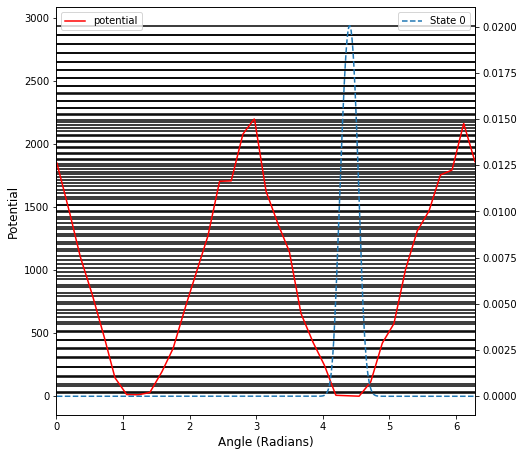

Examining state kidwell_es_scan_with_h2o_zpe_1


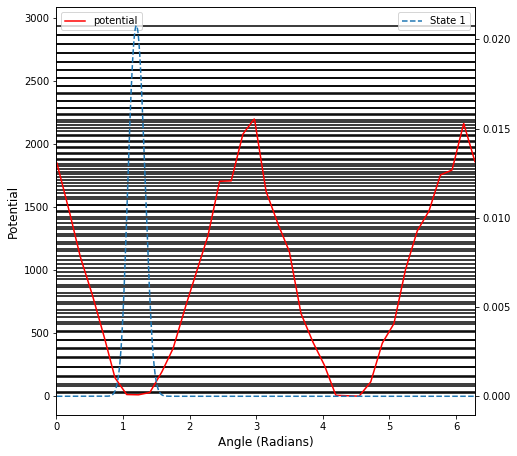

Examining state kidwell_es_scan_with_h2o_zpe_2


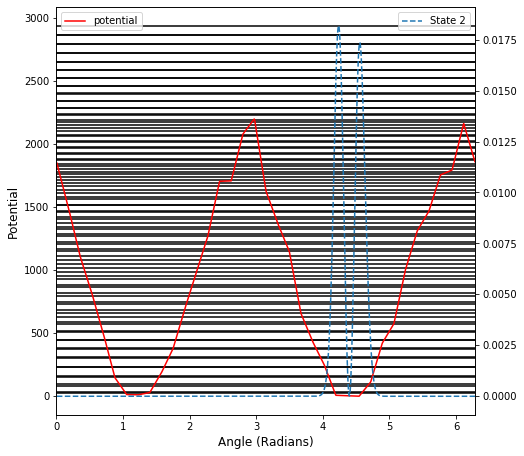

Examining state kidwell_es_scan_with_h2o_zpe_3


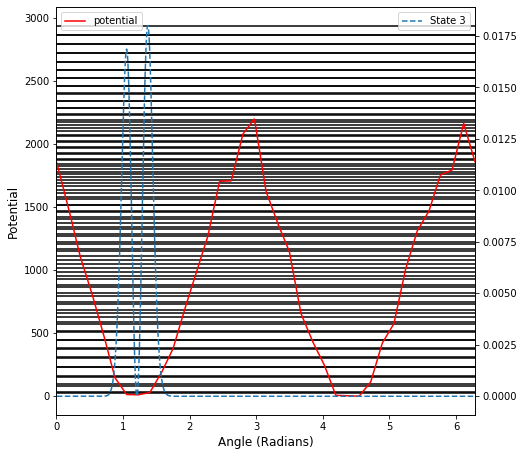

Examining state kidwell_es_scan_with_h2o_zpe_4


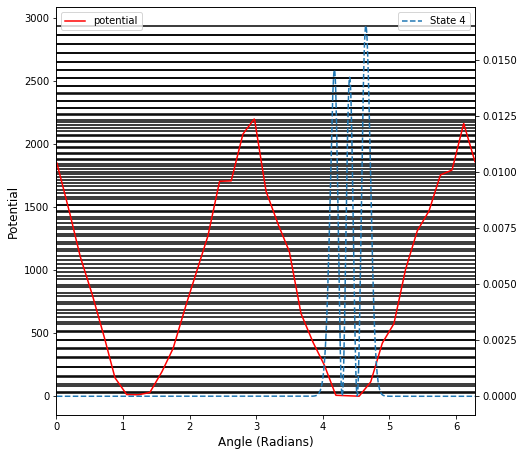

Examining state kidwell_es_scan_with_h2o_zpe_5


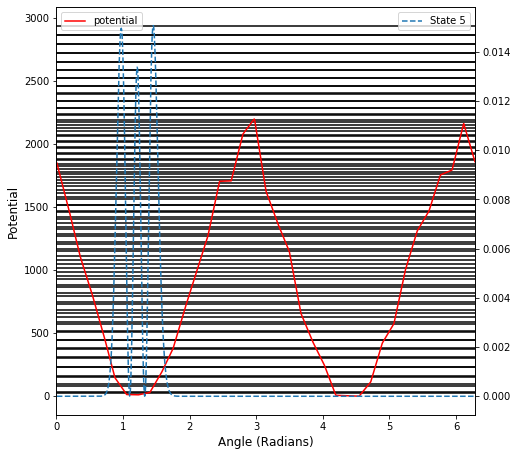

Examining state kidwell_es_scan_with_h2o_zpe_6


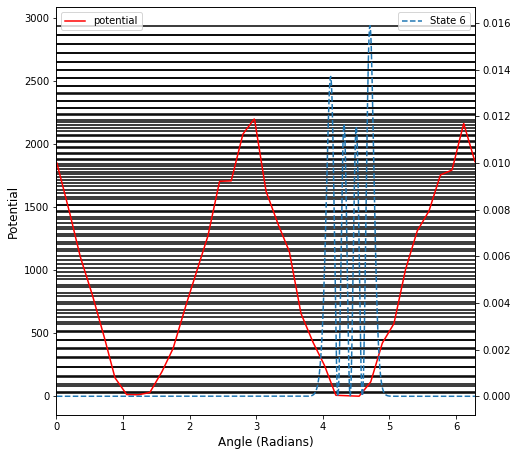

Examining state kidwell_es_scan_with_h2o_zpe_7


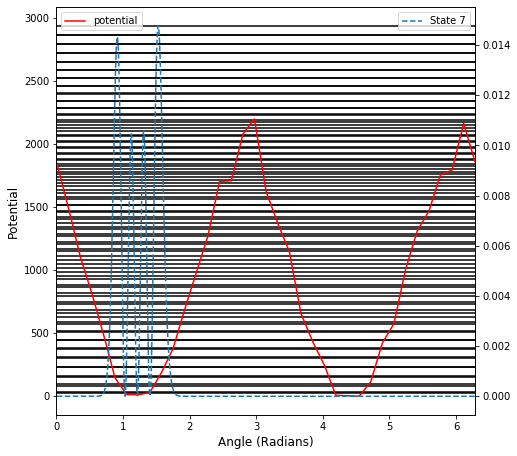

Examining state kidwell_es_scan_with_h2o_zpe_8


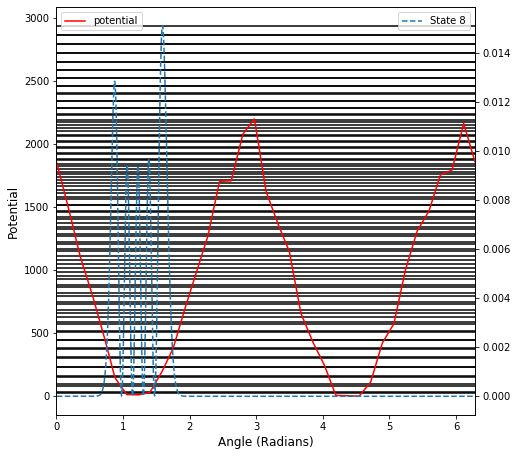

Examining state kidwell_es_scan_with_h2o_zpe_9


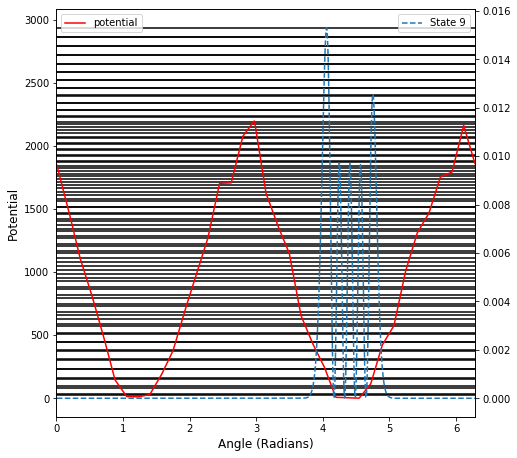

Examining state kidwell_es_scan_with_h2o_zpe_10


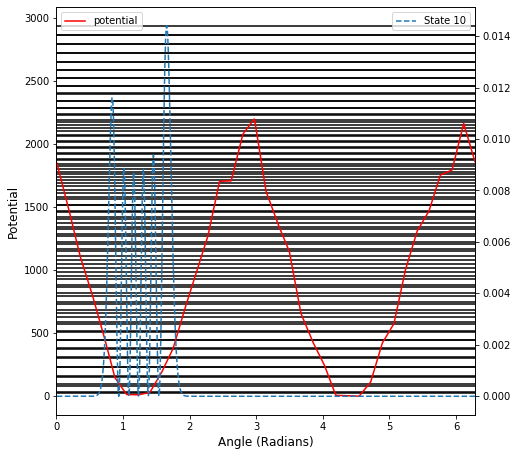

Examining state kidwell_es_scan_with_h2o_zpe_11


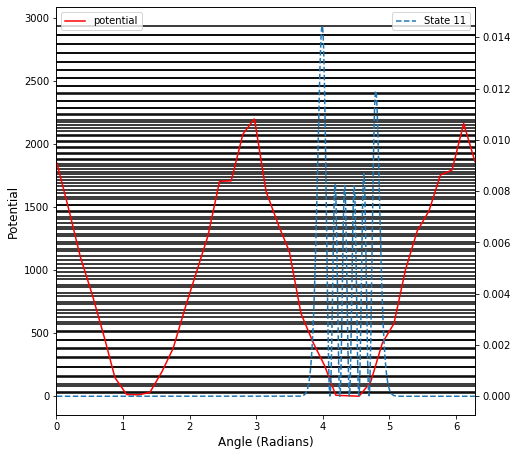

Examining state kidwell_es_scan_with_h2o_zpe_12


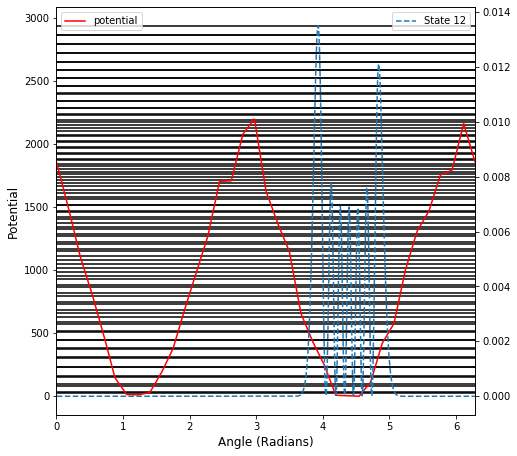

Examining state kidwell_es_scan_with_h2o_zpe_13


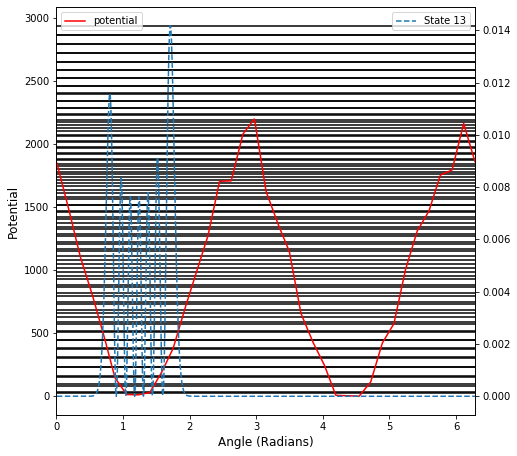

Examining state kidwell_es_scan_with_h2o_zpe_14


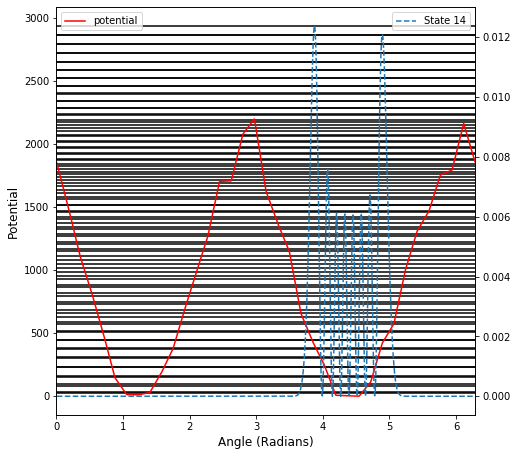

Examining state kidwell_es_scan_with_h2o_zpe_15


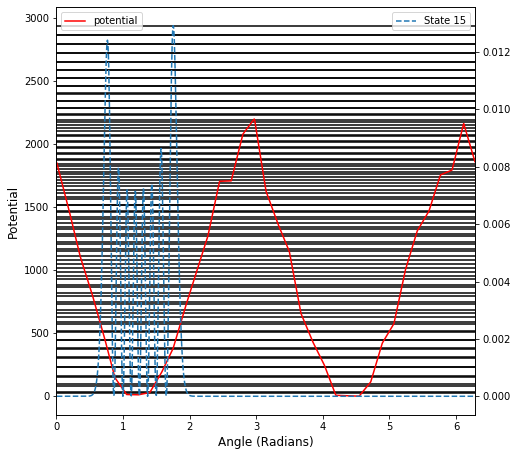

Examining state kidwell_es_scan_with_h2o_zpe_16


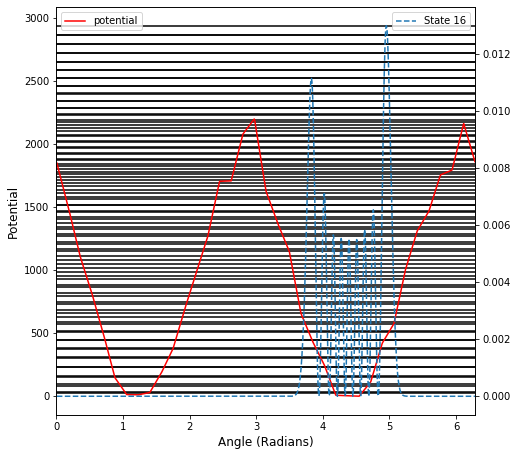

Examining state kidwell_es_scan_with_h2o_zpe_17


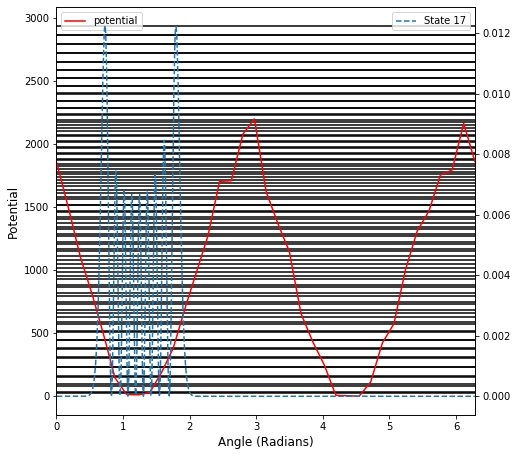

Examining state kidwell_es_scan_with_h2o_zpe_18


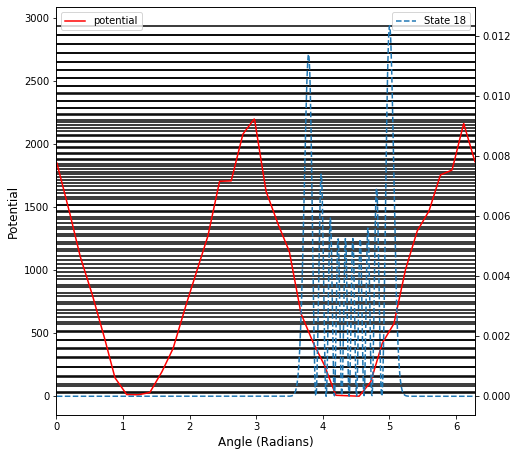

Examining state kidwell_es_scan_with_h2o_zpe_19


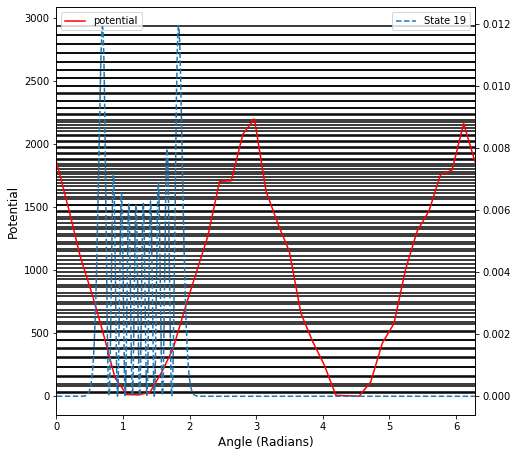

Examining state kidwell_es_scan_with_h2o_zpe_20


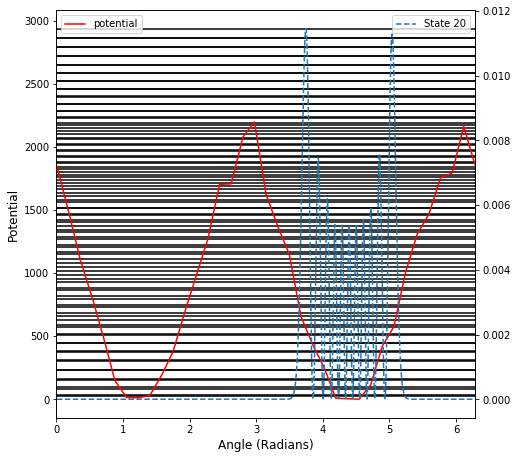

Examining state kidwell_es_scan_with_h2o_zpe_21


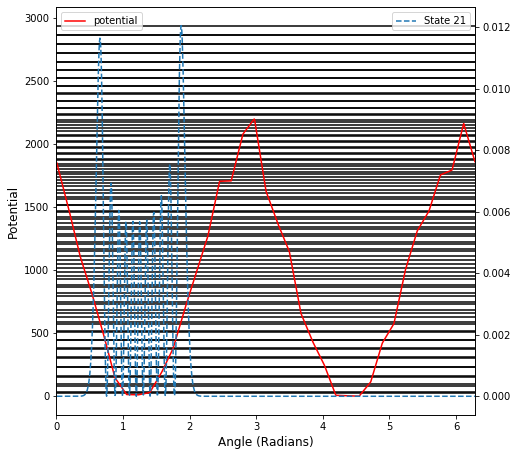

Examining state kidwell_es_scan_with_h2o_zpe_22


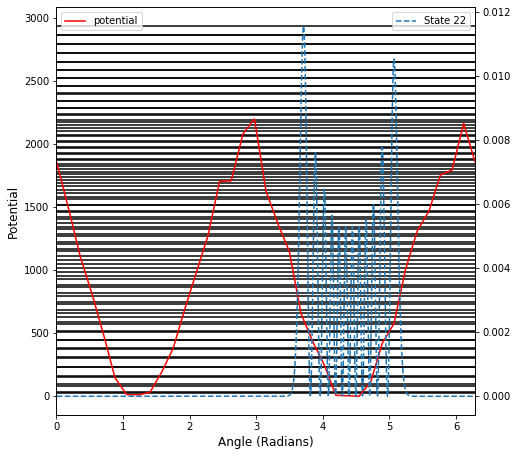

Examining state kidwell_es_scan_with_h2o_zpe_23


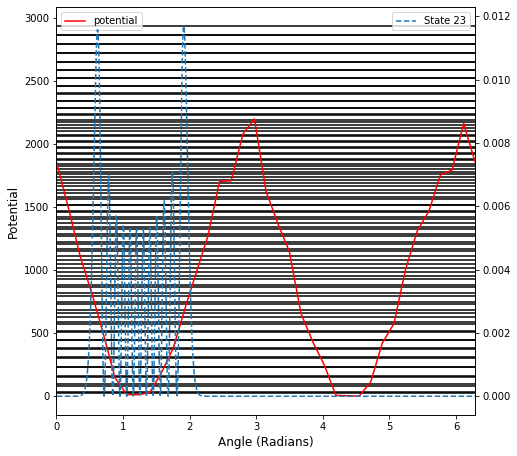

Examining state kidwell_es_scan_with_h2o_zpe_24


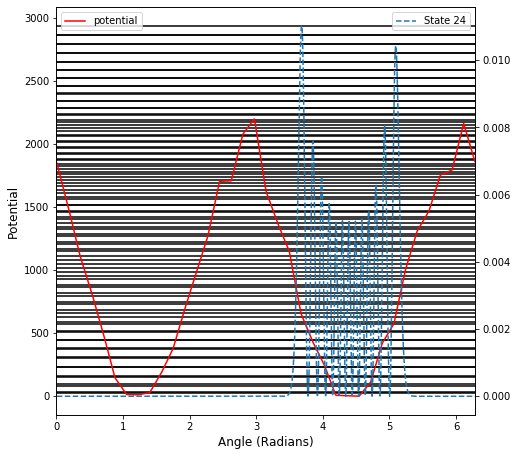

Examining state kidwell_es_scan_with_h2o_zpe_25


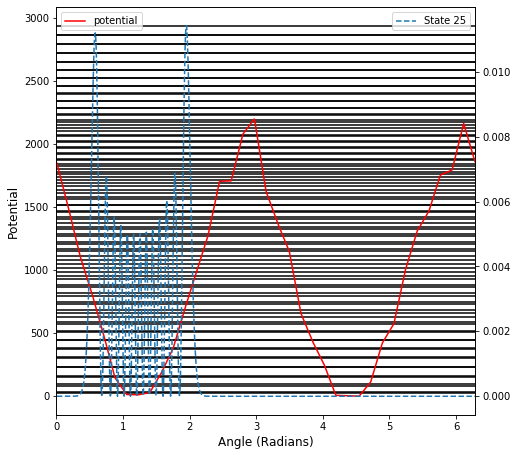

Examining state kidwell_es_scan_with_h2o_zpe_26


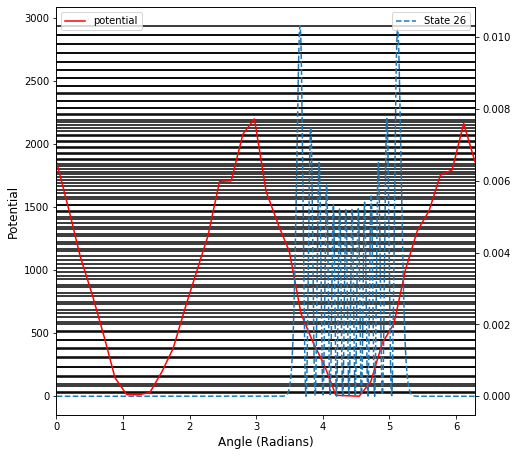

Examining state kidwell_es_scan_with_h2o_zpe_27


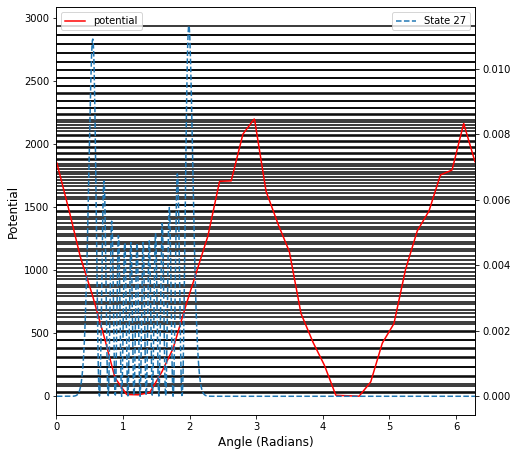

Examining state kidwell_es_scan_with_h2o_zpe_28


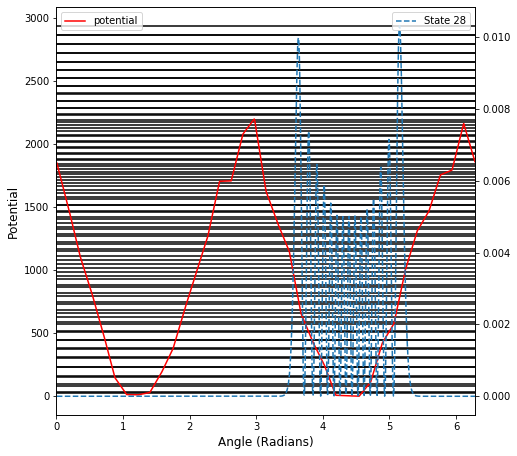

Examining state kidwell_es_scan_with_h2o_zpe_29


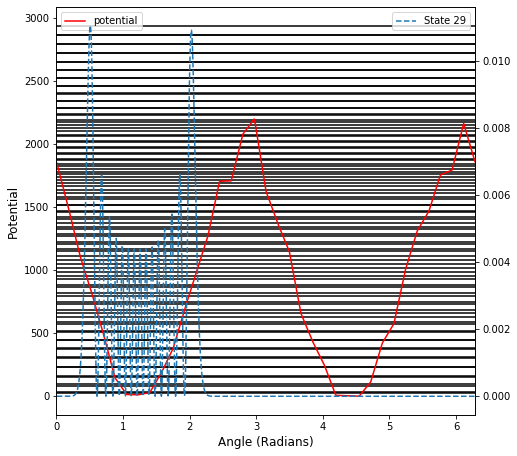

Examining state kidwell_es_scan_with_h2o_zpe_30


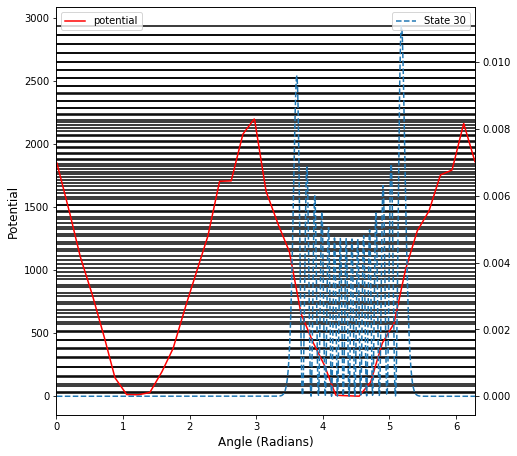

Examining state kidwell_es_scan_with_h2o_zpe_31


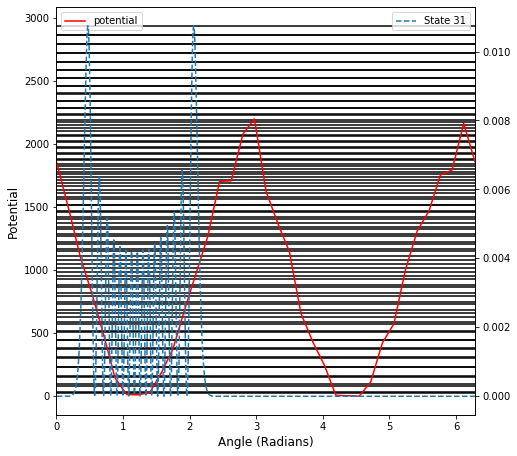

Examining state kidwell_es_scan_with_h2o_zpe_32


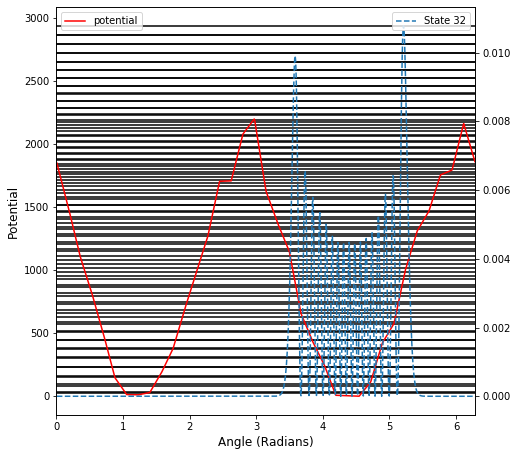

Examining state kidwell_es_scan_with_h2o_zpe_33


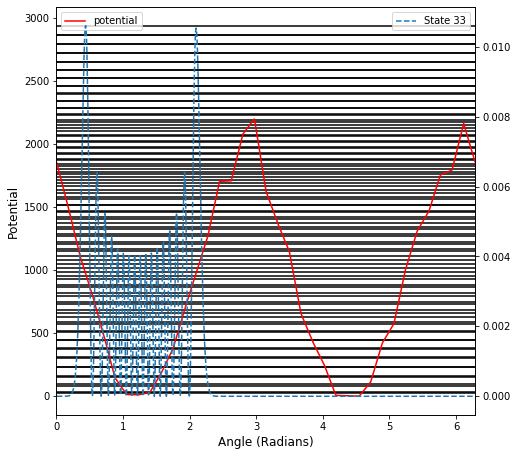

Examining state kidwell_es_scan_with_h2o_zpe_34


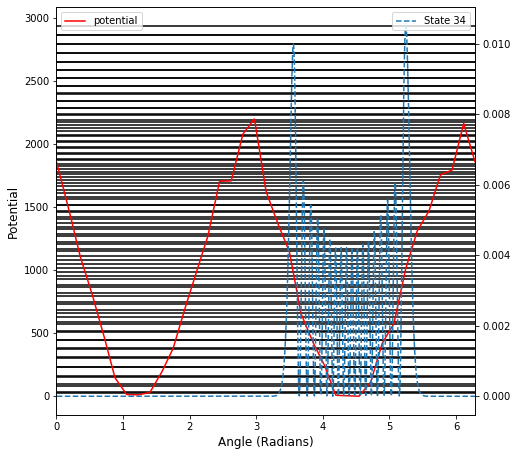

Examining state kidwell_es_scan_with_h2o_zpe_35


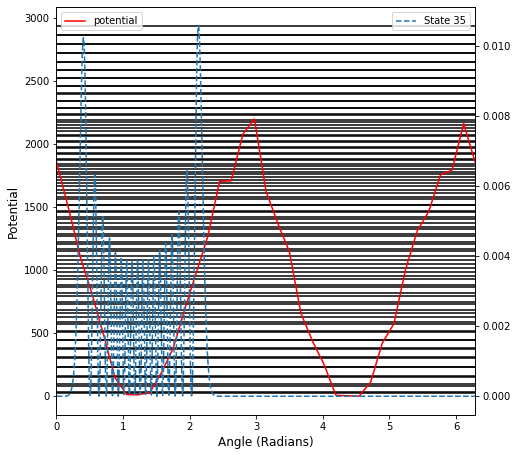

Examining state kidwell_es_scan_with_h2o_zpe_36


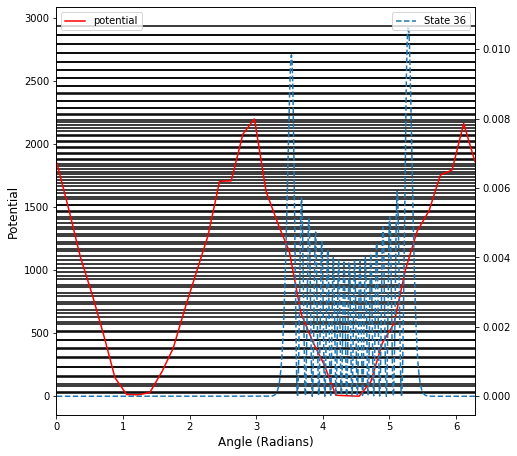

Examining state kidwell_es_scan_with_h2o_zpe_37


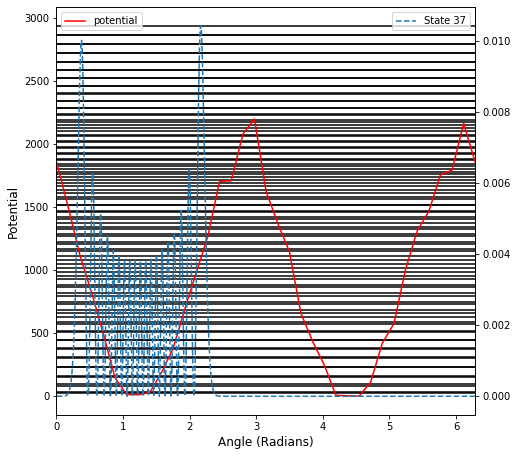

Examining state kidwell_es_scan_with_h2o_zpe_38


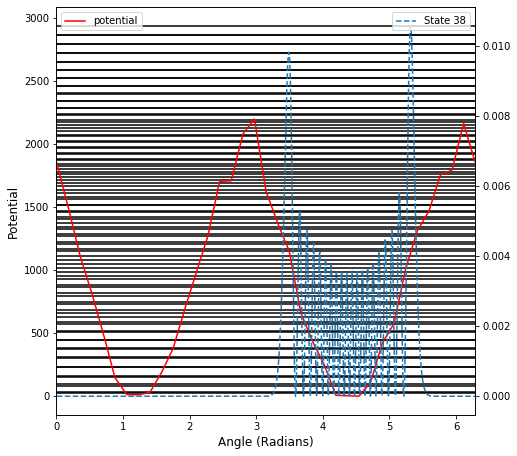

Examining state kidwell_es_scan_with_h2o_zpe_39


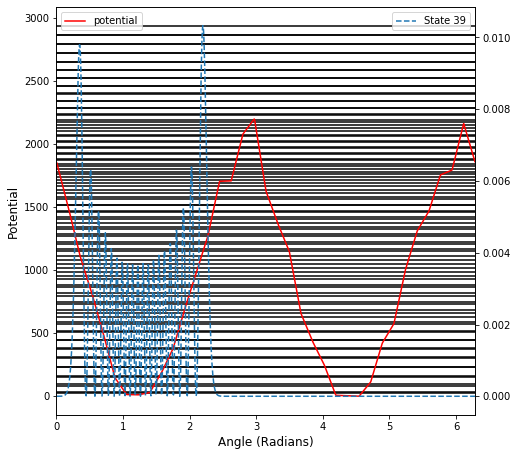

In [119]:
wavefunction_counter = 0

max_wavefunctions = 40

prefix = "kidwell_es_scan_with_h2o_zpe"

styles=['--','.','s','o']

for i in range(0,max_wavefunctions):
    plot_wavefunction_squared(state_dict=excited_state_dict,
                        state_num=i,prefix="kidwell_es_scan_with_h2o_zpe_",
                      plotting_potential_name="es_scan_with_water_fitted_zpe.dat",
                     potential="Excited State PES",mass=mass_ground)

Examining state kidwell_es_scan_no_h2o_0


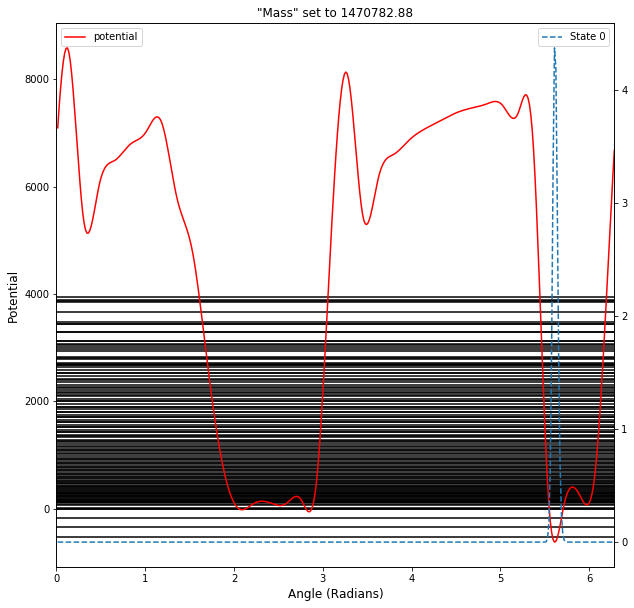

Examining state kidwell_es_scan_no_h2o_1


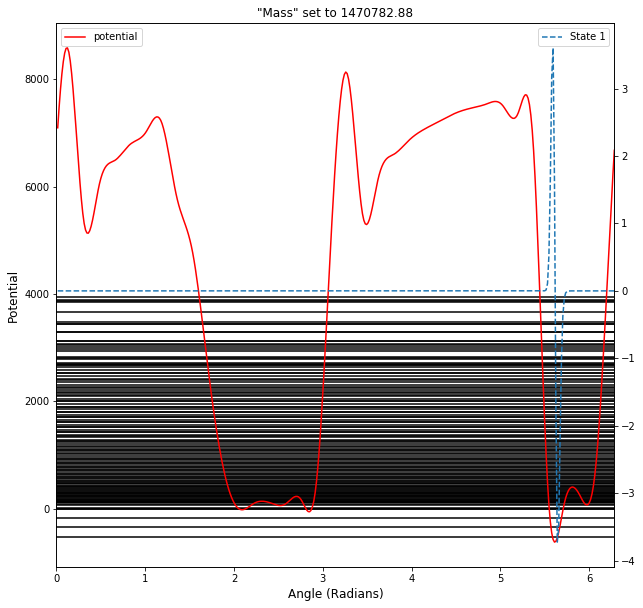

Examining state kidwell_es_scan_no_h2o_2


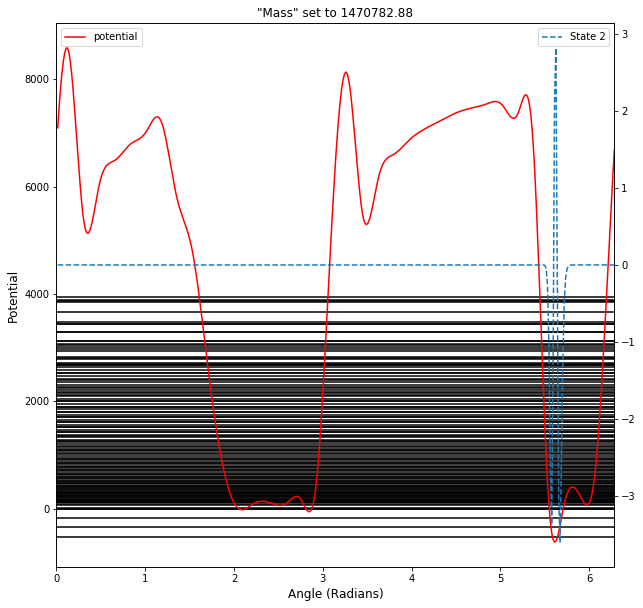

Examining state kidwell_es_scan_no_h2o_3


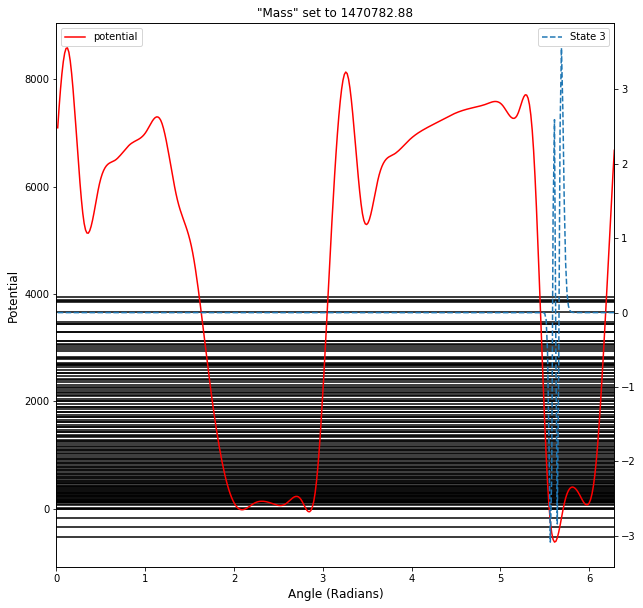

Examining state kidwell_es_scan_no_h2o_4


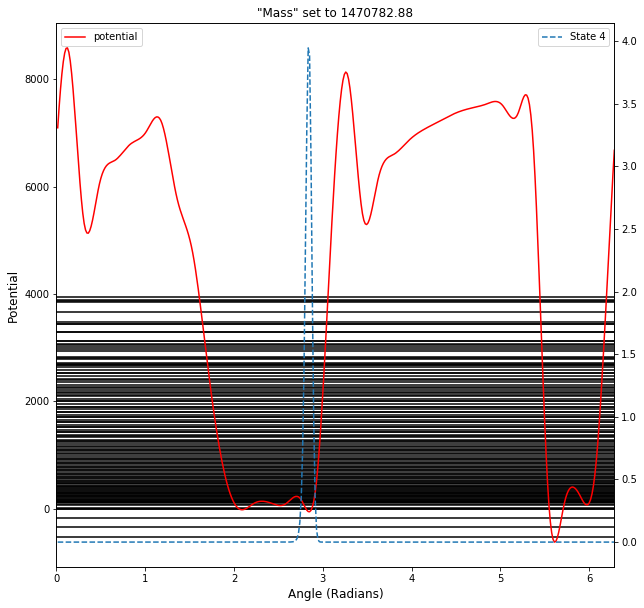

Examining state kidwell_es_scan_no_h2o_5


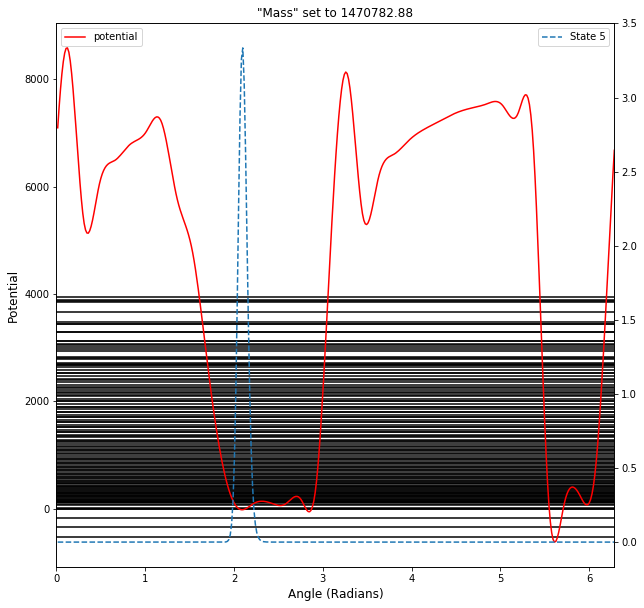

Examining state kidwell_es_scan_no_h2o_6


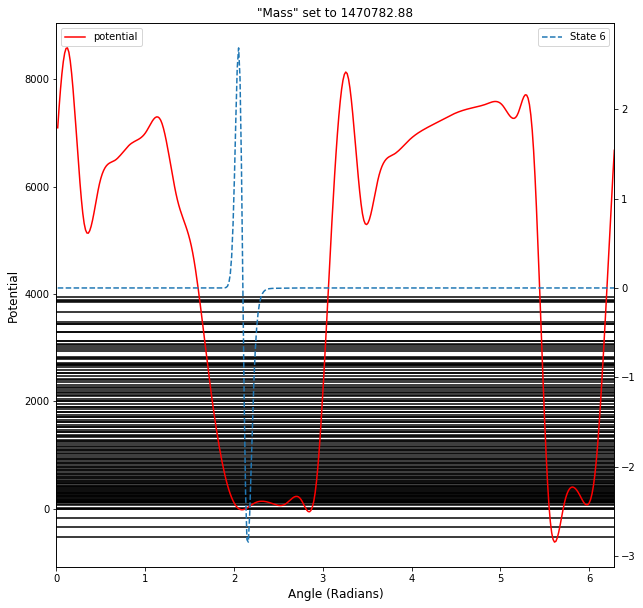

Examining state kidwell_es_scan_no_h2o_7


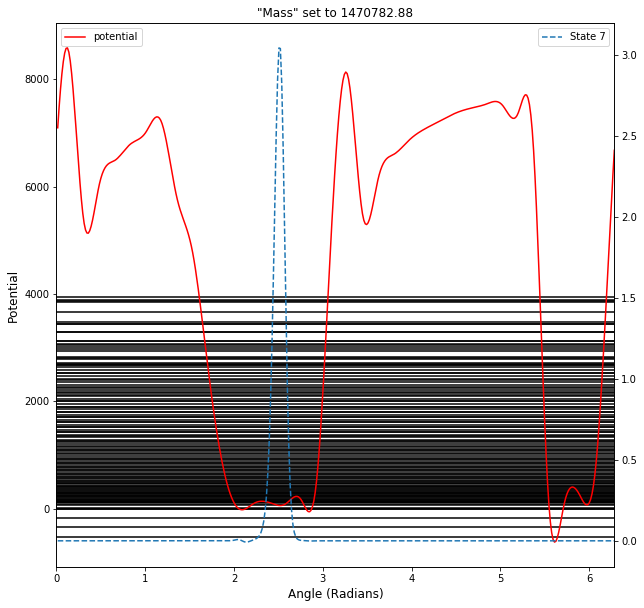

In [86]:
wavefunction_counter = 0

max_wavefunctions = 8

prefix = "kidwell_es_scan_no_h2o_"

styles=['--','.','s','o']

for i in range(0,8):
    plot_wavefunction(state_dict=excited_state_h2o_dict,
                        state_num=i,prefix="kidwell_es_scan_no_h2o_",
                      plotting_potential_name="es_scan_no_water_fitted.dat",
                     potential="Excited State PES",mass=mass_excited)

kidwell_gs_scan_no_h2o_0
kidwell_gs_scan_no_h2o_1
kidwell_gs_scan_no_h2o_2
kidwell_gs_scan_no_h2o_3
kidwell_gs_scan_no_h2o_4
kidwell_gs_scan_no_h2o_5
kidwell_gs_scan_no_h2o_6
kidwell_gs_scan_no_h2o_7
kidwell_gs_scan_no_h2o_8
kidwell_gs_scan_no_h2o_9
kidwell_gs_scan_no_h2o_10
kidwell_gs_scan_no_h2o_11
kidwell_gs_scan_no_h2o_12
kidwell_gs_scan_no_h2o_13
kidwell_gs_scan_no_h2o_14
kidwell_gs_scan_no_h2o_15
kidwell_gs_scan_no_h2o_16
kidwell_gs_scan_no_h2o_17
kidwell_gs_scan_no_h2o_18
kidwell_gs_scan_no_h2o_19
kidwell_gs_scan_no_h2o_20
kidwell_gs_scan_no_h2o_21
kidwell_gs_scan_no_h2o_22
kidwell_gs_scan_no_h2o_23
kidwell_gs_scan_no_h2o_24
kidwell_gs_scan_no_h2o_25
kidwell_gs_scan_no_h2o_26
kidwell_gs_scan_no_h2o_27
kidwell_gs_scan_no_h2o_28
kidwell_gs_scan_no_h2o_29
kidwell_gs_scan_no_h2o_30
kidwell_gs_scan_no_h2o_31
kidwell_gs_scan_no_h2o_32
kidwell_gs_scan_no_h2o_33
kidwell_gs_scan_no_h2o_34
kidwell_gs_scan_no_h2o_35
kidwell_gs_scan_no_h2o_36
kidwell_gs_scan_no_h2o_37
kidwell_gs_scan_no_h2o

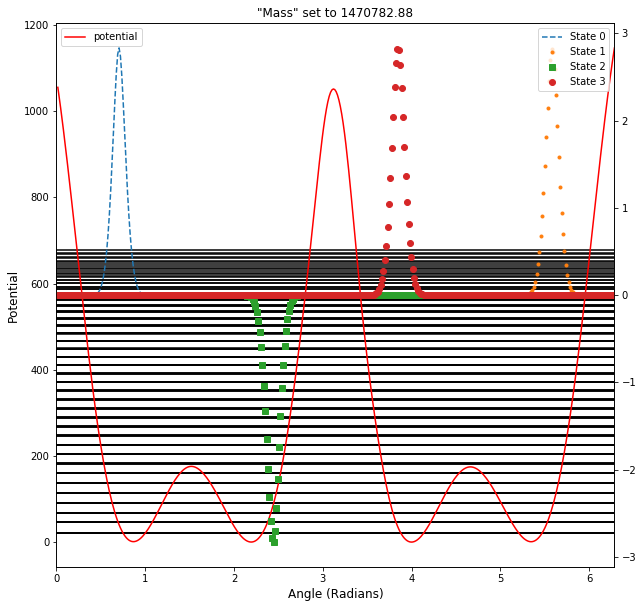

<Figure size 432x288 with 0 Axes>

In [56]:
# Plot Wavefunctions

# Ground state first

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 


ax.set_xlabel('Angle (Radians)', fontsize = 12)
ax.set_ylabel('Potential', fontsize = 12)
ax.set_title('\"Mass" set to '+str(mass_ground), fontsize = 12)
ax.set_xlim(0,2*np.pi)

plotting_potential_name = "gs_scan_with_water_fitted.dat"
potential = "Ground State PES"

# read in potential 
fitted_angle = np.loadtxt(plotting_potential_name,usecols=0)
fitted_energy = np.loadtxt(plotting_potential_name,usecols=1)

#ax.plot(angles, kidwell_gs_with_h2o_interpolate_values*AU_TO_WAVENUMBER,label='Kidwell GS Potential with Water', color='r',ls='-')
ax.plot(fitted_angle, fitted_energy*AU_TO_WAVENUMBER,label='potential', color='r',ls='-')

for state_key,state_information in ground_state_h2o_dict.items():
    energy = state_information['energy']
    if energy*AU_TO_WAVENUMBER < 2000:
        plt.hlines(energy*AU_TO_WAVENUMBER,0,2.0*np.pi)

# Now read in wavefunctions Plot the first few states

ax2 = ax.twinx()

wavefunction_counter = 0

max_wavefunctions = 4

styles=['--','.','s','o']

for state_key,state_information in ground_state_h2o_dict.items():
    print(state_key)
    angles = state_information['wavefunction_angles']
    wavefunction = state_information['wavefunction_values']
    if wavefunction_counter < max_wavefunctions:
        ax2.plot(angles, wavefunction, styles[wavefunction_counter] ,label='State '+str(wavefunction_counter))
    wavefunction_counter = wavefunction_counter+1

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()
plt.savefig('./'+'ground_state_pes_and_wavefunctions_mass_'+str(mass_ground)+'_.pdf')



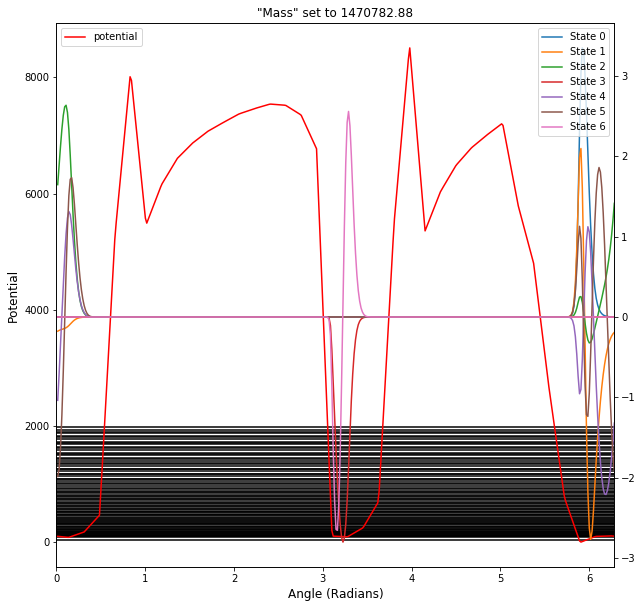

In [57]:
# Plot Wavefunctions

# Excited state now

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 


ax.set_xlabel('Angle (Radians)', fontsize = 12)
ax.set_ylabel('Potential', fontsize = 12)
ax.set_title('\"Mass" set to '+str(mass_ground), fontsize = 12)
ax.set_xlim(0,2*np.pi)

plotting_potential_name = "es_scan_no_water_fitted.dat"
potential = "Excited State PES"

# read in potential 
fitted_angle = np.loadtxt(plotting_potential_name,usecols=0)
fitted_energy = np.loadtxt(plotting_potential_name,usecols=1)

#ax.plot(angles, kidwell_gs_with_h2o_interpolate_values*AU_TO_WAVENUMBER,label='Kidwell GS Potential with Water', color='r',ls='-')
ax.plot(fitted_angle, fitted_energy*AU_TO_WAVENUMBER,label='potential', color='r',ls='-')

for state_key,state_information in excited_state_h2o_dict.items():
    energy = state_information['energy']
    if energy*AU_TO_WAVENUMBER < 2000:
        plt.hlines(energy*AU_TO_WAVENUMBER,0,2.0*np.pi)

# Now read in wavefunctions Plot the first few states

ax2 = ax.twinx()

wavefunction_counter = 0

max_wavefunctions = 7

for state_key,state_information in excited_state_h2o_dict.items():
    angles = state_information['wavefunction_angles']
    wavefunction = state_information['wavefunction_values']
    if wavefunction_counter < max_wavefunctions:
        ax2.plot(angles, wavefunction ,label='State '+str(wavefunction_counter))
    wavefunction_counter = wavefunction_counter+1
    
#kidwell_gs_dvr_angles = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_1.dat',usecols=0)
#kidwell_gs_dvr_wavefunction = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_1.dat',usecols=1)

#ax2.plot(kidwell_gs_dvr_angles, kidwell_gs_dvr_wavefunction, 'b-',label='Ground State Wavefunction')

#kidwell_1st_dvr_angles = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_2.dat',usecols=0)
#kidwell_1st_dvr_wavefunction = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_2.dat',usecols=1)

#ax2.plot(kidwell_1st_dvr_angles, kidwell_1st_dvr_wavefunction, 'g',label='1st Excited State Wavefunction')

#kidwell_2nd_dvr_angles = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_3.dat',usecols=0)
#kidwell_2nd_dvr_wavefunction = np.loadtxt('kidwell_es_scan_with_h2o_wavefunction_3.dat',usecols=1)

#ax2.plot(kidwell_2nd_dvr_angles, kidwell_2nd_dvr_wavefunction, 'y',label='2nd Excited State Wavefunction')


ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('./'+'excited_state_pes_and_wavefunctions_mass_'+str(mass_excited)+'.pdf')